# Simulating a Brain Dynamics Model

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) @[Chaoming Wang](https://github.com/chaoming0625)

One of the most important approaches of studying brain dynamics is building a dynamic model and doing simulation. Generally, there are two ways to construct a dynamic model. The first one is called spiking models, which attempt to finely simulate the activity of each neuron in the target population. They are named spiking models because the simulation process records the precise timing of spiking of every neuron. The second is called rate models, which regard a population of neurons with similar properties as a single firing unit and examine the firing rate of this population. In this section, we will illustrate how to build and simulate a spiking neural network, e.i. SNN.

To begin with, the BrainPy package should be imported:

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [2]:
bp.__version__

'2.3.0'

## Simulating an E-I balanced network

### Building an E-I balanced network

Firstly, let's try to build an E-I balanced network. It was proposed to interpret the irregular firing of neurons in the cortical area \[1\]. Since the structure of an E-I balanced network is relatively simple, it is a good practice that helps users to learn the basic paradigm of brain dynamic simulation in BrainPy. The structure of a E-I balanced network is as follows:

<center><img src="../_static/E_I_balance_network.png" width="400 px"></center>
<center>The stucture of an E-I Balanced Network</center>

An E-I balanced network is composed of two neuron groups and the synaptic connections between them. Specifically, they include:
1. a group of excitatory neurons, $\mathrm{E}$,
2. a group of inhibitory neurons, $\mathrm{I}$,
3. synaptic connections within the excitatory and inhibitory neuron groups, respectively, and 
4. the inter-connections between these two groups.

To construct the network, we need to define these components one by one. BrainPy provides plenty of handy built-in models for brain dynamic simulation. They are contained in ``brainpy.dyn``. Let's choose the simplest yet the most canonical neuron model, the Leaky Integrate-and-Fire (LIF) model, to build the excitatory and inhibitory neuron groups:

In [3]:
E = bp.neurons.LIF(3200, V_rest=-60., V_th=-50., V_reset=-60.,
                   tau=20., tau_ref=5., method='exp_auto',
                   V_initializer=bp.init.Normal(-60., 2.))

I = bp.neurons.LIF(800, V_rest=-60., V_th=-50., V_reset=-60.,
                   tau=20., tau_ref=5., method='exp_auto',
                   V_initializer=bp.init.Normal(-60., 2.))

When defining the LIF neuron group, the parameters can be tuned according to users' need. The first parameter denotes the number of neurons. Here the ratio of excitatory and inhibitory neurons is set to 4:1. ``V_rest`` denotes the resting potential, ``V_th`` denotes the firing threshold, ``V_reset`` denotes the reset value after firing, ``tau`` is the time constant, and ``tau_ref`` is the duration of the refractory period. ``method`` refers to the numerical integration method to be used in simulation.

Then the synaptic connections between these two groups can be defined as follows:

In [4]:
E2E = bp.synapses.Exponential(E, E, bp.conn.FixedProb(prob=0.02), g_max=0.6,
                              tau=5., output=bp.synouts.COBA(E=0.),
                              method='exp_auto')

E2I = bp.synapses.Exponential(E, I, bp.conn.FixedProb(prob=0.02), g_max=0.6,
                              tau=5., output=bp.synouts.COBA(E=0.),
                              method='exp_auto')

I2E = bp.synapses.Exponential(I, E, bp.conn.FixedProb(prob=0.02), g_max=6.7,
                              tau=10., output=bp.synouts.COBA(E=-80.),
                              method='exp_auto')

I2I = bp.synapses.Exponential(I, I, bp.conn.FixedProb(prob=0.02), g_max=6.7,
                              tau=10., output=bp.synouts.COBA(E=-80.),
                              method='exp_auto')

Here we use the Exponential synapse model (``bp.synapses.Exponential``) to simulate synaptic connections. Among the parameters of the model, the first two denotes the pre- and post-synaptic neuron groups, respectively. The third one refers to the connection types. In this example, we use ``bp.conn.FixedProb``, which connects the presynaptic neurons to postsynaptic neurons with a given probability (detailed information is available in [Synaptic Connection](../tutorial_toolbox/synaptic_connections.ipynb)). The following three parameters describes the dynamic properties of the synapse, and the last one is the numerical integration method as that in the LIF model.

After defining all the components, they can be combined to form a network:

In [5]:
net = bp.dyn.Network(E2E, E2I, I2E, I2I, E=E, I=I)

In the definition, neurons and synapses are given to the network. The excitatory and inhibitory neuron groups (`E` and `I`) are passed with a name, for they will be specifically operated in the simulation (here they will be given with input currents).

We have successfully constructed an E-I balanced network by using BrainPy's biult-in models. On the other hand, BrianPy also enables users to customize their own dynamic models such as neuron groups, synapses, and networks flexibly. In fact, ``brainpy.dyn.Network()`` is a simple example of customizing a network model. Please refer to [Dynamic Simulation](../tutorial_simulation/index.rst) for more information.

### Running a simulation

After building a SNN, we can use it for dynamic simulation. To run a simulation, we need to wrap the network model into a **runner** first. BrainPy provides ``DSRunner`` in ``brainpy.dyn``, which will be expanded in the [Runners](../tutorial_simulation/index.rst) tutorial. Users can initialize ``DSRunner`` as followed:

In [6]:
runner = bp.dyn.DSRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)],
                         dt=0.1)

To make dynamic simulation more applicable and powerful, users can monitor variable trajectories and give inputs to target neuron groups. Here we monitor the ``spike`` variable in the ``E`` and ``I`` LIF model, which refers to the spking status of the neuron group, and give a constant input to both neuron groups. The time interval of numerical integration ``dt`` (with the default value of 0.1) can also be specified.

More details of how to give inputs and monitors please refer to [Dynamic Simulation](../tutorial_simulation/index.rst).

After creating the runner, we can run a simulation by calling the runner:

In [7]:
runner.run(100)

  0%|          | 0/1000 [00:00<?, ?it/s]

where the calling function receives the simulation time (usually in milliseconds) as the input. BrainPy achieves an extraordinary simulation speed with the assistance of just-in-time (JIT) compilation. Please refer to [Just-In-Time Compilation](../tutorial_math/brainpy_transform_concept.ipynb) for more details.

The simulation results are stored as NumPy arrays in the monitors, and can be visualized easily:

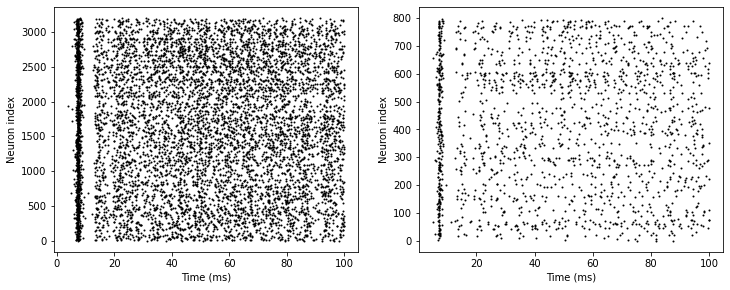

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4.5))

plt.subplot(121)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=False)
plt.subplot(122)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'], show=True)

In the code above, ``brianpy.visualize`` contains some useful functions to visualize simulation results based on the ``matplotlib`` package. Since the simulation results are stored as NumPy arrays, users can directly use ``matplotlib`` for visualization.

## Simulating a decision-making network

### Building a decision-making network

After learning how to build a E-I balanced network, we can try to handle a more complex model. In 2002, Wang proposed a decision-making model that could choose between two conflict inputs by accumulating evidence over time \[2\]. 

The structure of a decision-making network is as follows. Similar to the E-I balanced network, the decision-making network contains an excitatory and an inhibitory neuron group, forming connections within each group and between each other. What is different is that there are two specific subpopulation of neurons, A and B, that receive conflict inputs from outside (other brain areas). After given the external inputs, if the activity of A prevail over B, it means the network chooses option A, and vice versa.

<center><img src="../_static/dmnet_diagram.png" width="400 px"></center>
<center>The stucture of an E-I Balanced Network</center>

To construct a decision-making network, we should build all neuron groups:

1. Two excitatory neuron groups with different selectivity, $\mathrm{A}$ and $\mathrm{B}$, and other excitatory neurons, $\mathrm{N}$;
2. An inhibitory neuron group, $\mathrm{I}$;
3. Neurons generating external inputs $\mathrm{I_A}$ and $\mathrm{I_B}$;
4. Neurons generating noise to all neuron groups, $\mathrm{noise_A}$, $\mathrm{noise_B}$, $\mathrm{noise_N}$, and $\mathrm{noise_I}$.

And the synapse connection between them:

1. Connection from excitatory neurons to others, $\mathrm{A2A}$, $\mathrm{A2B}$, $\mathrm{A2N}$, $\mathrm{A2I}$, $\mathrm{B2A}$, $\mathrm{B2B}$, $\mathrm{B2N}$, $\mathrm{B2I}$, and $\mathrm{N2A}$, $\mathrm{N2B}$, $\mathrm{N2N}$, $\mathrm{N2I}$;
2. Connection from inhibitory neurons to others, $\mathrm{I2A}$, $\mathrm{I2B}$, $\mathrm{I2N}$, $\mathrm{I2I}$;
3. Connection from external inputs to selective neuron groups, $\mathrm{IA2A}$, $\mathrm{IB2B}$;
4. Connection from noise neurons to excitatory and inhibitory neurons, $\mathrm{noise2A}$, $\mathrm{noise2B}$, $\mathrm{noise2N}$, $\mathrm{noise2I}$.

Now let's build these neuron groups and connections.

First of all, to imitate the biophysical experiments, we define three periods:

In [9]:
pre_stimulus_period = 100.  # time before the external simuli are given
stimulus_period = 1000.  # time within which the external simuli are given
delay_period = 500.  # time after the external simuli are removed
total_period = pre_stimulus_period + stimulus_period + delay_period

To build $\mathrm{I_A}$ and $\mathrm{I_B}$, we shall define a class of neuron groups that can generate stochastic Possion stimulu. To define neuron groups, they should inherit from `brainpy.dyn.NeuGroup`.

In [10]:
class PoissonStim(bp.dyn.NeuGroup):
  def __init__(self, size, freq_mean, freq_var, t_interval, **kwargs):
    super(PoissonStim, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.freq_mean = freq_mean
    self.freq_var = freq_var
    self.t_interval = t_interval

    # initialize variables
    self.freq = bm.Variable(bm.zeros(1))
    self.freq_t_last_change = bm.Variable(bm.ones(1) * -1e7)
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.rng = bm.random.RandomState()

  def update(self, tdi):
    in_interval = bm.logical_and(pre_stimulus_period < tdi.t, tdi.t < pre_stimulus_period + stimulus_period)
    freq = bm.where(in_interval, self.freq[0], 0.)
    change = bm.logical_and(in_interval, (tdi.t - self.freq_t_last_change[0]) >= self.t_interval)
    self.freq[:] = bm.where(change, self.rng.normal(self.freq_mean, self.freq_var), freq)
    self.freq_t_last_change[:] = bm.where(change, tdi.t, self.freq_t_last_change[0])
    self.spike.value = self.rng.random(self.num) < self.freq[0] * tdi.dt / 1000.

Because there are too many neuron groups and connections, it will be much clearer if we define a new network class inheriting `brainpy.dyn.Network` to accommodate all these neurons and synapses:

In [11]:
class DecisionMaking(bp.dyn.Network):
  def __init__(self, scale=1., mu0=40., coherence=25.6, f=0.15, dt=bm.get_dt()):
    super(DecisionMaking, self).__init__()

    # initialize neuron-group parameters
    num_exc = int(1600 * scale)
    num_inh = int(400 * scale)
    num_A = int(f * num_exc)
    num_B = int(f * num_exc)
    num_N = num_exc - num_A - num_B
    poisson_freq = 2400.  # Hz

    # initialize synapse parameters
    w_pos = 1.7
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_ext2E_AMPA = 2.1  # nS
    g_ext2I_AMPA = 1.62  # nS
    g_E2E_AMPA = 0.05 / scale  # nS
    g_E2I_AMPA = 0.04 / scale  # nS
    g_E2E_NMDA = 0.165 / scale  # nS
    g_E2I_NMDA = 0.13 / scale  # nS
    g_I2E_GABAa = 1.3 / scale  # nS
    g_I2I_GABAa = 1.0 / scale  # nS

    # parameters of the AMPA synapse
    ampa_par = dict(delay_step=int(0.5 / dt), tau=2.0, output=bp.synouts.COBA(E=0.))

    # parameters of the GABA synapse
    gaba_par = dict(delay_step=int(0.5 / dt), tau=5.0, output=bp.synouts.COBA(E=-70.))

    # parameters of the NMDA synapse
    nmda_par = dict(delay_step=int(0.5 / dt), tau_decay=100, tau_rise=2.,
                    a=0.5, output=bp.synouts.MgBlock(E=0., cc_Mg=1.))

    # excitatory and inhibitory neuron groups, A, B, N, and I
    A = bp.neurons.LIF(num_A, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                       tau_ref=2., V_initializer=bp.init.OneInit(-70.))
    B = bp.neurons.LIF(num_B, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                       tau_ref=2., V_initializer=bp.init.OneInit(-70.))
    N = bp.neurons.LIF(num_N, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                       tau_ref=2., V_initializer=bp.init.OneInit(-70.))
    I = bp.neurons.LIF(num_inh, V_rest=-70., V_reset=-55., V_th=-50., tau=10., R=0.05,
                       tau_ref=1., V_initializer=bp.init.OneInit(-70.))

    # neurons generating external inputs, I_A and I_B
    IA = PoissonStim(num_A, freq_var=10., t_interval=50., freq_mean=mu0 + mu0 / 100. * coherence)
    IB = PoissonStim(num_B, freq_var=10., t_interval=50., freq_mean=mu0 - mu0 / 100. * coherence)

    # noise neurons
    self.noise_A = bp.neurons.PoissonGroup(num_A, freqs=poisson_freq)
    self.noise_B = bp.neurons.PoissonGroup(num_B, freqs=poisson_freq)
    self.noise_N = bp.neurons.PoissonGroup(num_N, freqs=poisson_freq)
    self.noise_I = bp.neurons.PoissonGroup(num_inh, freqs=poisson_freq)

    # connection from excitatory neurons to others
    self.N2B_AMPA = bp.synapses.Exponential(N, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.N2A_AMPA = bp.synapses.Exponential(N, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.N2N_AMPA = bp.synapses.Exponential(N, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
    self.N2I_AMPA = bp.synapses.Exponential(N, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
    self.N2B_NMDA = bp.synapses.NMDA(N, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.N2A_NMDA = bp.synapses.NMDA(N, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.N2N_NMDA = bp.synapses.NMDA(N, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
    self.N2I_NMDA = bp.synapses.NMDA(N, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

    self.B2B_AMPA = bp.synapses.Exponential(B, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos, **ampa_par)
    self.B2A_AMPA = bp.synapses.Exponential(B, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.B2N_AMPA = bp.synapses.Exponential(B, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
    self.B2I_AMPA = bp.synapses.Exponential(B, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
    self.B2B_NMDA = bp.synapses.NMDA(B, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos, **nmda_par)
    self.B2A_NMDA = bp.synapses.NMDA(B, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.B2N_NMDA = bp.synapses.NMDA(B, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
    self.B2I_NMDA = bp.synapses.NMDA(B, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

    self.A2B_AMPA = bp.synapses.Exponential(A, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.A2A_AMPA = bp.synapses.Exponential(A, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos, **ampa_par)
    self.A2N_AMPA = bp.synapses.Exponential(A, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
    self.A2I_AMPA = bp.synapses.Exponential(A, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
    self.A2B_NMDA = bp.synapses.NMDA(A, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.A2A_NMDA = bp.synapses.NMDA(A, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos, **nmda_par)
    self.A2N_NMDA = bp.synapses.NMDA(A, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
    self.A2I_NMDA = bp.synapses.NMDA(A, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

    # connection from inhibitory neurons to others
    self.I2B = bp.synapses.Exponential(I, B, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
    self.I2A = bp.synapses.Exponential(I, A, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
    self.I2N = bp.synapses.Exponential(I, N, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
    self.I2I = bp.synapses.Exponential(I, I, bp.conn.All2All(), g_max=g_I2I_GABAa, **gaba_par)

    # connection from external inputs to selective neuron groups
    self.IA2A = bp.synapses.Exponential(IA, A, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.IB2B = bp.synapses.Exponential(IB, B, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)

    # connectioni from noise neurons to excitatory and inhibitory neurons
    self.noise2B = bp.synapses.Exponential(self.noise_B, B, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.noise2A = bp.synapses.Exponential(self.noise_A, A, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.noise2N = bp.synapses.Exponential(self.noise_N, N, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.noise2I = bp.synapses.Exponential(self.noise_I, I, bp.conn.One2One(), g_max=g_ext2I_AMPA, **ampa_par)

    # add A, B, I, N to the class
    self.A = A
    self.B = B
    self.N = N
    self.I = I
    self.IA = IA
    self.IB = IB

Though the code seems longer than the E-I balanced network, the basic building paradigm is the same: building neuron groups and the connections among them.

### Running a simulation

After building it, the simulation process will be much the same as running a E-I balanced network. First we should wrap the network into a runner:

In [12]:
net = DecisionMaking(scale=1., coherence=25.6, mu0=40.)
runner = bp.dyn.DSRunner(net, monitors=['A.spike', 'B.spike', 'IA.freq', 'IB.freq'])

Then we call the runner to run the simulation:

In [13]:
runner.run(total_period)

  0%|          | 0/16000 [00:00<?, ?it/s]

Finally, we visualize the simulation result by using `matplotlib`:

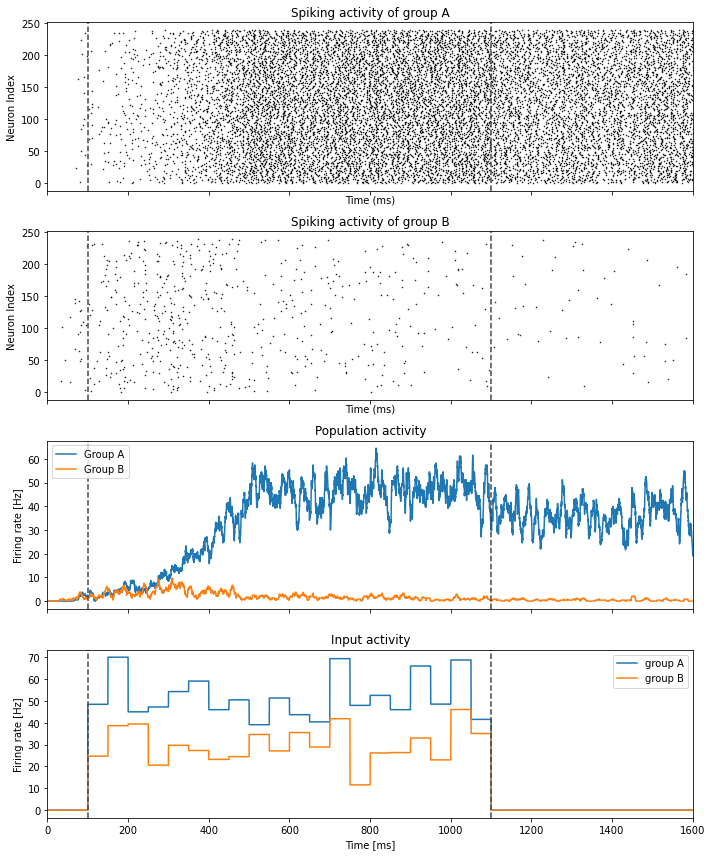

In [14]:
fig, gs = plt.subplots(4, 1, figsize=(10, 12), sharex='all')
t_start = 0.

# the raster plot of A
fig.add_subplot(gs[0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['A.spike'], markersize=1)
plt.title("Spiking activity of group A")
plt.ylabel("Neuron Index")

# the raster plot of A
fig.add_subplot(gs[1])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['B.spike'], markersize=1)
plt.title("Spiking activity of group B")
plt.ylabel("Neuron Index")

# the firing rate of A and B
fig.add_subplot(gs[2])
rateA = bp.measure.firing_rate(runner.mon['A.spike'], width=10.)
rateB = bp.measure.firing_rate(runner.mon['B.spike'], width=10.)
plt.plot(runner.mon.ts, rateA, label="Group A")
plt.plot(runner.mon.ts, rateB, label="Group B")
plt.ylabel('Firing rate [Hz]')
plt.title("Population activity")
plt.legend()

# the external stimuli
fig.add_subplot(gs[3])
plt.plot(runner.mon.ts, runner.mon['IA.freq'], label="group A")
plt.plot(runner.mon.ts, runner.mon['IB.freq'], label="group B")
plt.title("Input activity")
plt.ylabel("Firing rate [Hz]")
plt.legend()

for i in range(4):
  gs[i].axvline(pre_stimulus_period, linestyle='dashed', color=u'#444444')
  gs[i].axvline(pre_stimulus_period + stimulus_period, linestyle='dashed', color=u'#444444')

plt.xlim(t_start, total_period + 1)
plt.xlabel("Time [ms]")
plt.tight_layout()
plt.show()

For more information about brain dynamic simulation, please refer to [Dynamics Simulation](../tutorial_simulation/index.rst) in the BDP tutorial.

## Simulating a firing rate-based network

### Neural mass model

A neural mass models is a low-dimensional population model of spiking neural networks. It aims to describe the coarse grained activity of large populations of neurons and synapses. Mathematically, it is a dynamical system of non-linear ODEs. A classical neural mass model is the two-dimensional [Wilson–Cowan model](https://en.wikipedia.org/wiki/Wilson%E2%80%93Cowan_model). This model tracks the activity of an excitatory population of neurons coupled to an inhibitory population. With the augmentation of such models by more realistic forms of synaptic and network interaction they have proved especially successful in providing fits to neuro-imaging data.

Here, let's try the Wilson-Cowan model.

  0%|          | 0/100 [00:00<?, ?it/s]

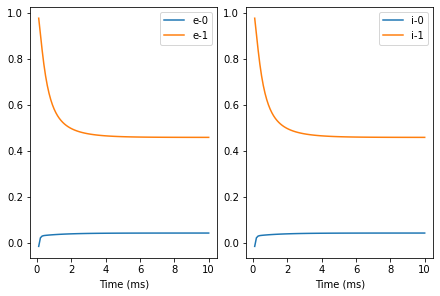

In [15]:
wc = bp.rates.WilsonCowanModel(2,
                               wEE=16., wIE=15., wEI=12., wII=3.,
                               E_a=1.5, I_a=1.5, E_theta=3., I_theta=3.,
                               method='exp_euler_auto',
                               x_initializer=bm.asarray([-0.2, 1.]),
                               y_initializer=bm.asarray([0.0, 1.]))

runner = bp.dyn.DSRunner(wc, monitors=['x', 'y'], inputs=['input', -0.5])
runner.run(10.)

fig, gs = bp.visualize.get_figure(1, 2, 4, 3)
ax = fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.x, plot_ids=[0, 1], legend='e', ax=ax)
ax = fig.add_subplot(gs[0, 1])
bp.visualize.line_plot(runner.mon.ts, runner.mon.x, plot_ids=[0, 1], legend='i', ax=ax, show=True)

We can see this model at least has two stable states.

**Bifurcation diagram**

With the automatic analysis module in BrainPy, we can easily inspect the bifurcation digram of the model. Bifurcation diagrams can give us an overview of how different parameters of the model affect its dynamics (the details of the automatic analysis support of BrainPy please see the introduction in [Analyzing a Dynamical Model](./analysis.ipynb) and tutorials in [Dynamics Analysis](../tutorial_analysis/index.rst)). In this case, we make ``x_ext`` as a bifurcation parameter, and try to see how the system behavior changes with the change of ``x_ext``.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 40000 candidates
I am trying to filter out duplicate fixed points ...
	Found 579 fixed points.
I am plotting the limit cycle ...


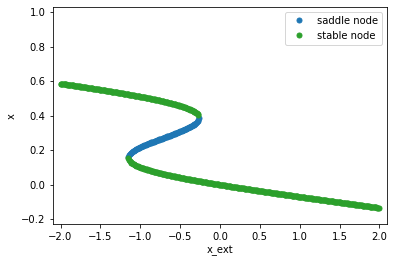

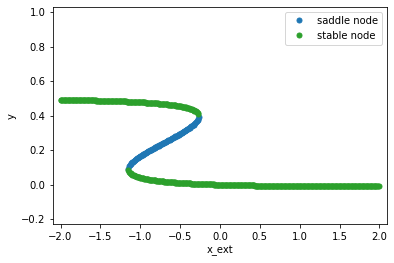

In [16]:
bf = bp.analysis.Bifurcation2D(
    wc,
    target_vars={'x': [-0.2, 1.], 'y': [-0.2, 1.]},
    target_pars={'x_ext': [-2, 2]},
    pars_update={'y_ext': 0.},
    resolutions={'x_ext': 0.01}
)
bf.plot_bifurcation()
bf.plot_limit_cycle_by_sim(duration=500)
bf.show_figure()

Similarly, simulating and analyzing a rate-based FitzHugh-Nagumo model is also a piece of cake by using BrainPy.

I am making bifurcation analysis ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 20000 candidates
I am trying to filter out duplicate fixed points ...
	Found 200 fixed points.
I am plotting the limit cycle ...


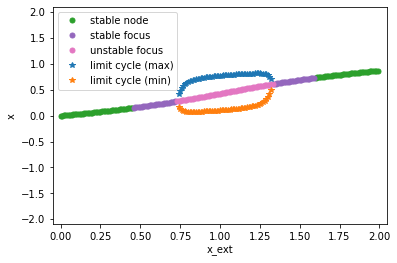

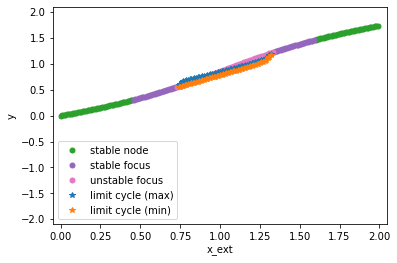

In [17]:
fhn = bp.rates.FHN(1, method='exp_auto')

bf = bp.analysis.Bifurcation2D(
    fhn,
    target_vars={'x': [-2, 2], 'y': [-2, 2]},
    target_pars={'x_ext': [0, 2]},
    pars_update={'y_ext': 0.},
    resolutions={'x_ext': 0.01}
)
bf.plot_bifurcation()
bf.plot_limit_cycle_by_sim(duration=500)
bf.show_figure()

In this model, we find that when the external input ``x_ext`` has the value in [0.72, 1.4], the model will generate limit cycles. We can verify this by simulation.

  0%|          | 0/1000 [00:00<?, ?it/s]

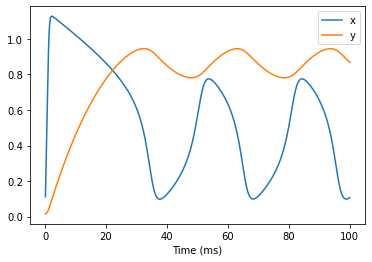

In [18]:
runner = bp.dyn.DSRunner(fhn, monitors=['x', 'y'], inputs=['input', 1.0])
runner.run(100.)

bp.visualize.line_plot(runner.mon.ts, runner.mon.x, legend='x')
bp.visualize.line_plot(runner.mon.ts, runner.mon.y, legend='y', show=True)

### Whole-brain model

A rate-based whole-brain model is a network model which consists of coupled brain regions. Each brain region is represented by a neural mass model which is connected to other brain regions according to the underlying network structure of the brain, also known as the connectome. In order to illustrate how to use BrainPy's support for whole-brain modeling, here we provide a processed data in the following link:

- A processed data from ConnectomeDB of the Human Connectome Project (HCP): [https://share.weiyun.com/wkPpARKy](https://share.weiyun.com/wkPpARKy)

Please download the dataset and place it in your favorite ``PATH``.

In [19]:
PATH = './data/hcp.npz'

In general, a dataset for whole-brain modeling consists of the following parts:

1\. A structural connectivity matrix which captures the synaptic connection strengths between brain areas. It often derived from DTI tractography of the whole brain. The connectome is then typically parcellated in a preferred atlas (for example the AAL2 atlas) and the number of axonal fibers connecting each brain area with every other area is counted. This number serves as an indication of the synaptic coupling strengths between the areas of the brain.

2\. A delay matrix which calculated from the average length of the axonal fibers connecting each brain area with another.

3\. A set of functional data that can act as a target for model optimization. Resting-state fMRI offers an easy and fairly unbiased way for calibrating whole-brain models. EEG data could be used as well.

Now, let's load the dataset.

In [20]:
data = bm.load(PATH)

In [21]:
# The structural connectivity matrix

data['Cmat'].shape

(80, 80)

In [22]:
# The fiber length matrix

data['Dmat'].shape

(80, 80)

In [23]:
# The functional data for 7 subjects

data['FCs'].shape

(7, 80, 80)

Let's have a look what the data looks like.

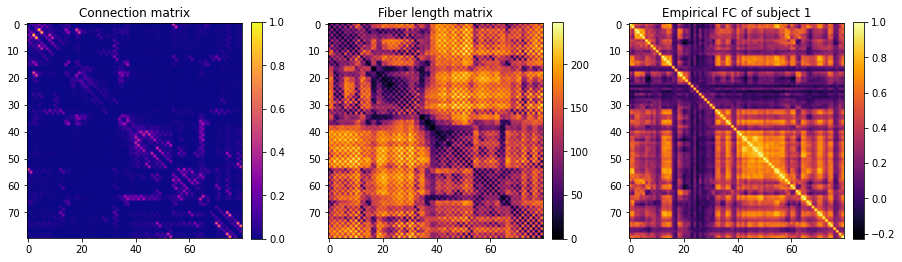

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'

fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.subplots_adjust(wspace=0.28)

im = axs[0].imshow(data['Cmat'])
axs[0].set_title("Connection matrix")
fig.colorbar(im, ax=axs[0],fraction=0.046, pad=0.04)
im = axs[1].imshow(data['Dmat'], cmap='inferno')
axs[1].set_title("Fiber length matrix")
fig.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
im = axs[2].imshow(data['FCs'][0], cmap='inferno')
axs[2].set_title("Empirical FC of subject 1")
fig.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)
plt.show()

Let's first get the delay matrix according to the fiber length matrix, the signal transmission speed between areas, and the numerical integration step ``dt``. Here, we assume the axonal transmission speed is 20 and the simulation time step ``dt=0.1`` ms.

In [25]:
sigal_speed = 20.

# the number of the delay steps
delay_mat = data['Dmat'] / sigal_speed / bm.get_dt()
delay_mat = bm.asarray(delay_mat, dtype=bm.int_)

The connectivity matrix can be directly obtained through the structural connectivity matrix, which times a global coupling strength parameter ``gc``. b

In [26]:
gc = 1.

conn_mat = bm.asarray(data['Cmat'] * gc)

# It is necessary to exclude the self-connections
bm.fill_diagonal(conn_mat, 0)

We now are ready to instantiate a whole-brain model with the neural mass model and the dataset the processed before.

In [27]:
class WholeBrainNet(bp.dyn.Network):
  def __init__(self, Cmat, Dmat):
    super(WholeBrainNet, self).__init__()

    self.fhn = bp.rates.FHN(
        80,
        x_ou_sigma=0.01,
        y_ou_sigma=0.01,
        method='exp_auto'
    )
    self.syn = bp.synapses.DiffusiveCoupling(
        self.fhn.x,
        self.fhn.x,
        var_to_output=self.fhn.input,
        conn_mat=Cmat,
        delay_steps=Dmat.astype(bm.int_),
        initial_delay_data=bp.init.Uniform(0, 0.05)
    )

In [28]:
net = WholeBrainNet(conn_mat, delay_mat)

runner = bp.dyn.DSRunner(net, monitors=['fhn.x'], inputs=['fhn.input', 0.72])
runner.run(6e3)

  0%|          | 0/60000 [00:00<?, ?it/s]

The simulated results can be used to estimate the functional correlation matrix.

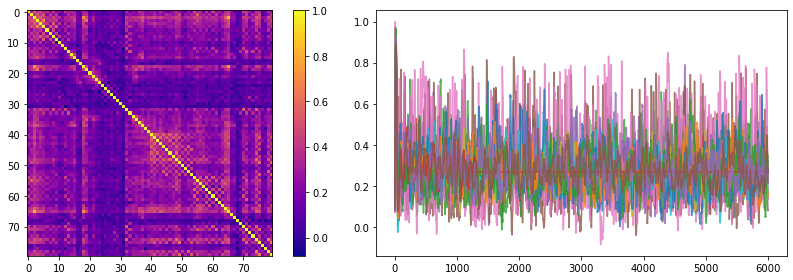

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fc = bp.measure.functional_connectivity(runner.mon['fhn.x'])
ax = axs[0].imshow(fc)
plt.colorbar(ax, ax=axs[0])
axs[1].plot(runner.mon.ts, runner.mon['fhn.x'][:, ::5], alpha=0.8)
plt.tight_layout()
plt.show()

We can compute the element-wise Pearson correlation of the functional connectivity matrices of the simulated data to the empirical data to estimate how well the model captures the inter-areal functional correlations found in empirical resting-state recordings.

In [30]:
scores = [bp.measure.matrix_correlation(fc, fcemp)
          for fcemp in data['FCs']]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(bm.mean(bm.asarray(scores))))

Correlation per subject: ['0.6', '0.48', '0.58', '0.49', '0.56', '0.5', '0.48']
Mean FC/FC correlation: 0.53


## References

1. van Vreeswijk, C., & Sompolinsky, H. (1996). Chaos in neuronal networks with balanced excitatory and inhibitory activity. Science (New York, N.Y.), 274(5293), 1724–1726. https://doi.org/10.1126/science.274.5293.1724

2. Wang X. J. (2002). Probabilistic decision making by slow reverberation in cortical circuits. Neuron, 36(5), 955–968. https://doi.org/10.1016/s0896-6273(02)01092-9